# Link prediction with Node2Vec

In this notebook we will perform a drug-drug interaction prediction based on node representation/embeddings. The embeddings are computed with Node2Vec and a binary classifier will predict the existance of the link.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

from google.colab import drive
drive.mount("/content/drive", force_remount=True)


     |████████████████████████████████| 440kB 12.6MB/s 
     |████████████████████████████████| 235kB 44.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
Mounted at /content/drive


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

### Data Loading



In [4]:
path = 'drive/My Drive/Data Intensive Computing/' # Blanca's
#path = 'drive/My Drive/KTH/Courses/Data Intensive Computing/' # Amrita's

In [5]:
# load data
edges = pd.read_csv(path+'dataset_new/edges.csv')
edges = edges.drop(['drug_A_id', 'drugbank_id'],axis=1)
edges = edges.rename(columns={"drug_A_node_id": "source", "drug_B_node_id": "target"})
edges = edges.dropna()
edges = edges.astype({'source': 'int'})
edges.head(5)

,source,target
0,10315,9529
1,4259,9529
2,61,9529
3,1026,3685
4,6146,1028


In [6]:
# check type of data
print(edges.dtypes)

source    int64
target    int64
dtype: object


In [7]:
# cast the edges to string 
edges = edges.astype('str')
print(edges.dtypes)

source    object
target    object
dtype: object


In [9]:
# graph creation
graph = StellarGraph(edges=edges, node_type_default="corner", edge_type_default="line")
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 4270, Edges: 2668170

 Node types:
  corner: [4270]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [2668170]
        Weights: all 1 (default)
        Features: none


## Data Splitting

###  Test Graph


In [10]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.01 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed. example_test is the set of positive/negatie links.
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.01, method="global")

print(graph_test.info())

** Sampled 26681 positive and 26681 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 4270, Edges: 2641489

 Node types:
  corner: [4270]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [2641489]
        Weights: all 1 (default)
        Features: none


### Train Graph


In [11]:
# Do the same process to compute a training subset from within the test graph
# EdgeSplitter takes in graph_test as graph to sample edges from and graph as original datasets.
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.01, method="global")

(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 26414 positive and 26414 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 4270, Edges: 2615075

 Node types:
  corner: [4270]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [2615075]
        Weights: all 1 (default)
        Features: none


## Node2Vec

To calculate node embeddings

In [12]:
p = 1.0                                 # random walk parameter
q = 1.0                                 # random walk parameter
dimensions = 128                        # dimensionality of embeddings
num_walks = 10                          # number of walks from each node
walk_length = 80                        # length of random walk
window_size = 10                        # window size for word2vec
num_iter = 1                            # number of SGD iterations
workers = multiprocessing.cpu_count()   # random walk parameter

In [13]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter)

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [14]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 42700


## Train and evaluate the link prediction model


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, plot_roc_curve 


### Link embeddings ###

def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


### Training of the classifier ###

def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


### Evaluation of the classifiers for the 4 operators and selection of best ###

def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator, plot_curve
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score_roc, score_acc, score_f1, score_rec, score_pres = evaluate_model(clf, 
                                                    link_features_test, 
                                                    link_labels_test)
    if plot_curve == 1:
      plot_roc_curve(clf,link_features_test,link_labels_test)

    return score_roc, score_acc, score_f1, score_rec, score_pres


### Evaluation of the best model with test_graph ###

def evaluate_model(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    
    # evaluate with auc as metric
    auc = roc_auc_score(link_labels, predicted[:, positive_column])
    predicted = clf.predict(link_features)
    #plot_roc_curve(clf,link_features,link_labels)

    
    # other metrics
    acc = accuracy_score(link_labels, predicted)
    f1 = f1_score(link_labels, predicted)
    rec = recall_score(link_labels, predicted)
    pres = precision_score(link_labels, predicted)
    

    return auc, acc, f1, rec, pres

In [16]:
# operators 

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator)

    score_auc, score_acc, score_f1, score_rec, score_pres = evaluate_link_prediction_model(clf,
                                           examples_model_selection,
                                           labels_model_selection,
                                           embedding_train, 
                                           binary_operator,
                                           0)

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "auc_score": score_auc,
        "acc_score": score_acc,
        "f1_score": score_f1,
        "precision_score": score_pres,
        "recall_score": score_rec}


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [17]:
# compute results and print
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["auc_score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["auc_score"], result["acc_score"], 
      result["f1_score"], result["precision_score"], result["recall_score"],) for result in results],
    columns=("name", "ROC AUC score","accuracy","f1_score", "precision", "recall"),
).set_index("name")



Best result from 'operator_hadamard'


,ROC AUC score,accuracy,f1_score,precision,recall
name,,,,,
operator_hadamard,0.920000,0.850988,0.848405,0.866289,0.831245
operator_l1,0.865237,0.789203,0.796640,0.771833,0.823094
operator_l2,0.866403,0.791929,0.803882,0.762420,0.850113
operator_avg,0.738146,0.670781,0.671104,0.672631,0.669585


### Evaluation

In [18]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 42700


ROC AUC score on test set using 'operator_hadamard': 0.8047725978128928
Accuracy score on test set using operator_hadamard : 0.5190959859075747


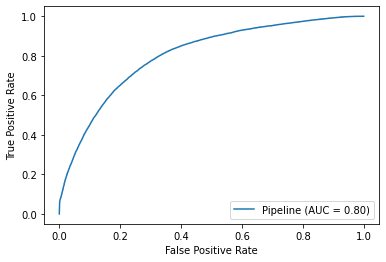

In [19]:
test_auc, test_acc, test_f1,test_rec,test_prec = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
    1)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_auc}"
)
print("Accuracy score on test set using", 
      best_result['binary_operator'].__name__,
      ":", test_acc)
print("f1-score on test set using", 
      best_result['binary_operator'].__name__,
      ":", test_f1)
print("Precision on test set using", 
      best_result['binary_operator'].__name__,
      ":", test_prec)
print("Recall on test set using", 
      best_result['binary_operator'].__name__,
      ":", test_rec)

### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm ([link](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

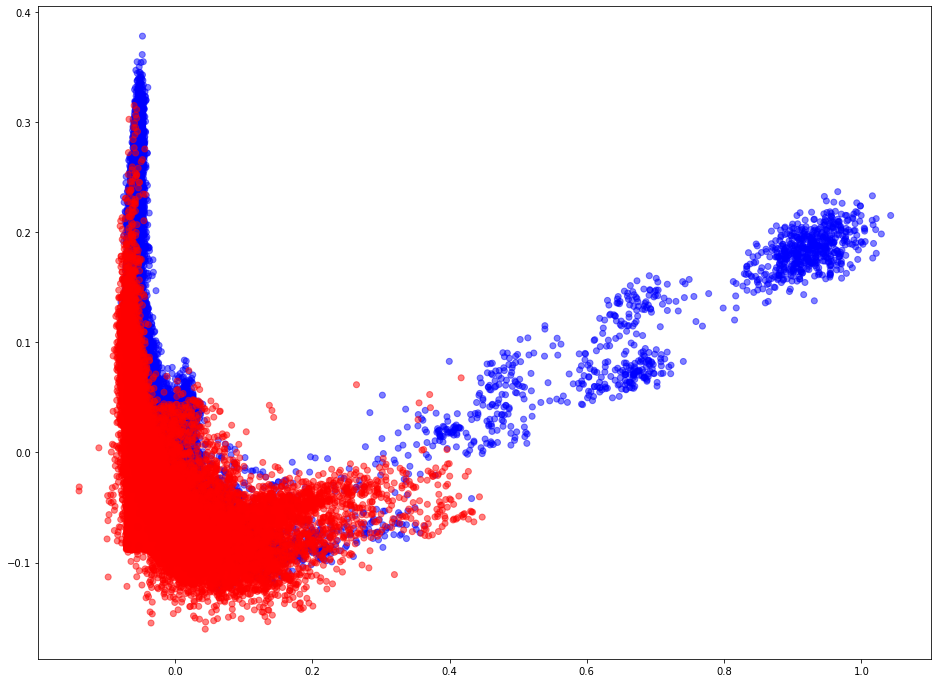

In [20]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/node2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/node2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>